<a href="https://colab.research.google.com/github/brunograssano/TP-Organizacion-de-datos/blob/main/TP_Datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico: Analisis Exploratorio - Organizacion de Datos

## Introduccion

En el presente trabajo se propone realizar un analisis de los datos recolectados por una empresa en los ultimos 2 meses sobre los clientes que fueron a ver la pelicula Frozen 3. La encuesta consistia en una serie de preguntas personales que concluia si el cliente volveria a ese cine si salia Frozen 4.

El objetivo de la empresa es poder dirigir futuras campañas de marketing digital en base a esta informacion recolectada

## Objetivos

El objetivo del notebook es:
*   Entender los datos
*   Ver como los datos se relacionan entre si
*   Poder sacar alguna conclusión o descubrir un patrón a partir de estos
*   Indicar cuáles son los factores más importantes que determinan si un usuario va a ir al cine a ver Frozen 4 o no.




## Configuraciones Iniciales

Primero cargamos las bibliotecas que se van a ir usando a lo largo del trabajo, y realizamos la configuracion para los graficos que armemos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from math import pi

## Carga y limpieza del set de datos

Cargamos ambos Datasets y vemos de dejarlos listos para comenzar el trabajo

In [3]:
usuario_volveria_df = pd.read_csv('tp-2020-2c-train-cols1.csv')
usuario_volveria_df.head()

,id_usuario,volveria
0,117,0
1,658,0
2,794,0
3,455,0
4,173,1


In [4]:
info_fiumark_df = pd.read_csv('tp-2020-2c-train-cols2.csv')
info_fiumark_df.head()

,tipo_de_sala,nombre,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,4d,Señor Camilo Pedro,117,hombre,73.5,0,0,59258;,1,NaN,fiumark_quilmes
1,4d,Señora Raquel Angelica,658,mujer,35.0,1,1,586:6;,2,NaN,fiumark_quilmes
2,normal,Señor Antonio Federico,794,hombre,NaN,0,0,"RE""39822",3,NaN,fiumark_chacarita
3,4d,Señor Osvaldo Aureliano,455,hombre,NaN,0,0,"C17""4:39",1,NaN,fiumark_palermo
4,4d,Señorita Rita Eudosia,173,mujer,4.0,1,1,569964,2,NaN,fiumark_palermo


Analizamos primero los tipos de datos que tienen ambos dataframes con el objetivo de poder convertirlos a otros que puedan llegar a ser mas utiles.

In [5]:
usuario_volveria_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id_usuario  801 non-null    int64
 1   volveria    801 non-null    int64
dtypes: int64(2)
memory usage: 12.6 KB


Notamos que la columna de 'volveria' es de tipo int64, cuando solamente tiene valores que pueden ser 0 o 1. Un mejor tipo de dato para este caso puede ser un int8. Esto permitiria ahorrar memoria. (Aunque en este caso no sean muchos datos)

In [6]:
usuario_volveria_df['volveria'] = usuario_volveria_df['volveria'].astype(np.int8)

Observamos en la informacion del dataframe que hay 801 registros y que para este caso no se encuentran valores nulos

Veamos ahora el otro dataframe. Este dataframe contiene la informacion respecto de las personas. 

In [7]:
info_fiumark_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tipo_de_sala   801 non-null    object 
 1   nombre         801 non-null    object 
 2   id_usuario     801 non-null    int64  
 3   genero         801 non-null    object 
 4   edad           641 non-null    float64
 5   amigos         801 non-null    int64  
 6   parientes      801 non-null    int64  
 7   id_ticket      801 non-null    object 
 8   precio_ticket  801 non-null    int64  
 9   fila           177 non-null    object 
 10  nombre_sede    799 non-null    object 
dtypes: float64(1), int64(4), object(6)
memory usage: 69.0+ KB


Notamos una gran cantidad de valores nulos en la columna "fila" y algunos en "edad" y "nombre_sede". Como las columnas que tienen los valores nulos pueden llegar a ser relevantes para el analisis, siendo este el caso de las columnas "fila" y "edad" decidimos crear la categoria "No responde" para el caso de "fila".

In [8]:
info_fiumark_df['fila'].fillna("No responde",inplace=True)

Ahora vemos la cantidad de valores unicos para las columnas de tipo objeto, para poder determinar a cuales les corresponderia tener un tipo categorico.

In [9]:
info_fiumark_df.select_dtypes(include=['object']).nunique()

tipo_de_sala      3
nombre          801
genero            2
id_ticket       635
fila              3
nombre_sede       3
dtype: int64

In [10]:
info_fiumark_df["tipo_de_sala"] = info_fiumark_df["tipo_de_sala"].astype("category")
info_fiumark_df["genero"] = info_fiumark_df["genero"].astype("category")
info_fiumark_df["nombre_sede"] = info_fiumark_df["nombre_sede"].astype("category")
info_fiumark_df["fila"] = info_fiumark_df["fila"].astype("category")


Otra cosa que observamos es que las edades estan en formato de float, lo cual nos resulto llamativo, por lo que decidimos cortar los valores, llevandolos al piso.

In [11]:
info_fiumark_df['edad'] = info_fiumark_df['edad'].apply(np.floor) 
#info_fiumark_df['edad'] = info_fiumark_df['edad'].astype(np.int) # VER QUE HACEMOS CON LOS VALORES NULOS, PREGUNTAR SI ES VALIDO TOMAR EL 3er CUANTIL POR LA EDAD

Pudimos observar que hay muchos valores faltantes en la columna de 'edad'. Lo que decidimos hacer fue utilizar la columna 'nombre', que incluye sufijos como 'Señora' o 'Señorita' para rellenar el valor de edad.

Lo primero que hacemos es crear una nueva columna 'sufijo' a partir de los valores de nombres anteriores.

In [12]:
sufijos_y_nombres = info_fiumark_df.nombre.str.split(pat = ' ', n= 1,expand = True)
sufijos_y_nombres.columns = ['sufijo', 'nombre']
info_fiumark_df.drop('nombre', axis = 1, inplace = True)
info_fiumark_df = pd.concat([ sufijos_y_nombres, info_fiumark_df ], axis = 'columns')

In [13]:
info_fiumark_df

,sufijo,nombre,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,id_ticket,precio_ticket,fila,nombre_sede
0,Señor,Camilo Pedro,4d,117,hombre,73.0,0,0,59258;,1,No responde,fiumark_quilmes
1,Señora,Raquel Angelica,4d,658,mujer,35.0,1,1,586:6;,2,No responde,fiumark_quilmes
2,Señor,Antonio Federico,normal,794,hombre,NaN,0,0,"RE""39822",3,No responde,fiumark_chacarita
3,Señor,Osvaldo Aureliano,4d,455,hombre,NaN,0,0,"C17""4:39",1,No responde,fiumark_palermo
4,Señorita,Rita Eudosia,4d,173,mujer,4.0,1,1,569964,2,No responde,fiumark_palermo
...,...,...,...,...,...,...,...,...,...,...,...,...
796,Señor,Bernardo Melesio,normal,448,hombre,37.0,0,0,3359;6,3,No responde,fiumark_palermo
797,Señorita,Lidia Catalina,3d,636,mujer,31.0,0,0,45988:,2,No responde,fiumark_palermo
798,Señor,Arturo Antenor,4d,848,hombre,38.0,0,0,56;435,1,No responde,fiumark_chacarita
799,Señorita,Natividad Sofia,3d,304,mujer,NaN,0,0,4487;5,2,adelante,fiumark_quilmes


Ahora reemplazamos la edad de las 'Señoras' que no contestaron la edad por la mediana de las que si contestaron. Hacemos lo mismo para las 'Señoritas'

Ademas creamos una columna 'autocompletamos_edad' para indicar cuales de estas edades fueron completadas por nosotros

In [14]:
mediana_edad_senioras = info_fiumark_df[info_fiumark_df['sufijo'] == 'Señora'].edad.dropna().median()
mediana_edad_senioritas = info_fiumark_df[info_fiumark_df['sufijo'] == 'Señorita'].edad.dropna().median()

In [15]:
info_fiumark_df['autocompletamos_edad'] = False

In [16]:
info_fiumark_df.loc[(info_fiumark_df['sufijo'] == 'Señora') & (info_fiumark_df['edad'].isnull()),'autocompletamos_edad'] = True
info_fiumark_df.loc[(info_fiumark_df['sufijo'] == 'Señorita') & (info_fiumark_df['edad'].isnull()),'autocompletamos_edad'] = True

In [17]:
info_fiumark_df.loc[info_fiumark_df['sufijo'] == 'Señorita','edad'] = info_fiumark_df.loc[info_fiumark_df['sufijo'] == 'Señorita','edad'].fillna(mediana_edad_senioritas)
info_fiumark_df.loc[info_fiumark_df['sufijo'] == 'Señora','edad'] = info_fiumark_df.loc[info_fiumark_df['sufijo'] == 'Señora','edad'].fillna(mediana_edad_senioras) 

Tambien observamos que entre los datos que nos fueron entregados se encuentra el codigo de ticket: "id_ticket". Consideramos
que la informacion en ella es irrelevante para nuestros propositos y por lo tanto la eliminamos. Esta decision se debe a que parece que el codigo del ticket tiene forma de ser generada de forma aleatoria y no da la impresion de estar relacionada con la variable de interes para el analisis.

In [18]:
info_fiumark_df.drop(columns='id_ticket',inplace=True)

Habiendo hecho esos cambios, finalmente nos queda el dataframe de la siguiente forma. En el proceso se redujo el uso de memoria, pasando de 69.0KB a 41.2KB.

In [19]:
info_fiumark_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   sufijo                801 non-null    object  
 1   nombre                801 non-null    object  
 2   tipo_de_sala          801 non-null    category
 3   id_usuario            801 non-null    int64   
 4   genero                801 non-null    category
 5   edad                  687 non-null    float64 
 6   amigos                801 non-null    int64   
 7   parientes             801 non-null    int64   
 8   precio_ticket         801 non-null    int64   
 9   fila                  801 non-null    category
 10  nombre_sede           799 non-null    category
 11  autocompletamos_edad  801 non-null    bool    
dtypes: bool(1), category(4), float64(1), int64(4), object(2)
memory usage: 48.2+ KB


In [20]:
info_fiumark_df.head()

,sufijo,nombre,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede,autocompletamos_edad
0,Señor,Camilo Pedro,4d,117,hombre,73.0,0,0,1,No responde,fiumark_quilmes,False
1,Señora,Raquel Angelica,4d,658,mujer,35.0,1,1,2,No responde,fiumark_quilmes,False
2,Señor,Antonio Federico,normal,794,hombre,NaN,0,0,3,No responde,fiumark_chacarita,False
3,Señor,Osvaldo Aureliano,4d,455,hombre,NaN,0,0,1,No responde,fiumark_palermo,False
4,Señorita,Rita Eudosia,4d,173,mujer,4.0,1,1,2,No responde,fiumark_palermo,False


Por ultimo, dejamos unidos ambos dataframes.

In [21]:
info_fiumark_df = info_fiumark_df.merge(usuario_volveria_df,on='id_usuario')
info_fiumark_df.head()

,sufijo,nombre,tipo_de_sala,id_usuario,genero,edad,amigos,parientes,precio_ticket,fila,nombre_sede,autocompletamos_edad,volveria
0,Señor,Camilo Pedro,4d,117,hombre,73.0,0,0,1,No responde,fiumark_quilmes,False,0
1,Señora,Raquel Angelica,4d,658,mujer,35.0,1,1,2,No responde,fiumark_quilmes,False,0
2,Señor,Antonio Federico,normal,794,hombre,NaN,0,0,3,No responde,fiumark_chacarita,False,0
3,Señor,Osvaldo Aureliano,4d,455,hombre,NaN,0,0,1,No responde,fiumark_palermo,False,0
4,Señorita,Rita Eudosia,4d,173,mujer,4.0,1,1,2,No responde,fiumark_palermo,False,1


## Analisis exploratorio

Empecemos el analisis haciendonos algunas preguntas sencillas, y en cada caso si es que surge alguna nueva pregunta interesante se continuara su desarrollo en esa seccion.  
* ¿Es el genero una variable determinante a la hora de decidir ver la secuela?
* ¿Como es la relacion con la edad?
* ¿Afecta en algo el ir a ditintos tipos de sala la decision?
* ¿Hay mas gente que iria a la secuela si fue a una sede en particular?
* ¿El precio fue determinante?
* ¿La ubicacion en la sala importa?


### ¿Cuanto afecta el genero a la hora de ir a ver la siguiente pelicula?

Veamos primero que proporcion de las personas que fueron a ver la pelicula son hombres y que proporcion mujeres:

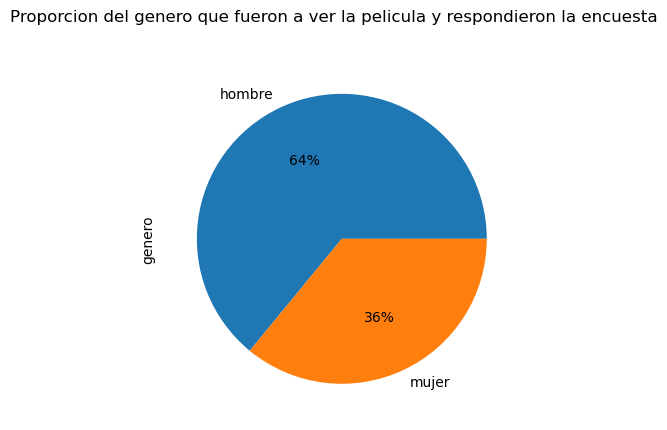

In [22]:
plt.figure(figsize=(6.4, 4.8), dpi=100)
genero = info_fiumark_df['genero'].value_counts().sort_index().plot(kind='pie', autopct='%1.0f%%')
plt.suptitle('Proporcion del genero que fueron a ver la pelicula y respondieron la encuesta')
plt.show()

Observamos que casi dos tercios de las personas que fueron a ver la pelicula son hombres y un tercio mujeres.
Si bien a primera vista esto parece indicar que la pelicula atrae mas a hombres que a mujeres debemos analizar si
estos hombres y mujeres disfrutaron la pelicula lo suficiente como para volver a verla.

Buscamos ver ahora que proporcion de los hombres y mujeres que fueron a ver la pelicula volverian a ver la secuela. Esto se puede obtener de forma sencilla.

A priori esperamos que la proporcion de mujeres que deciden ir a ver la secuela sea mucho mayor que la de los hombres que fueron a ver la pelicula.

In [23]:
porcentaje_generos_volveria = info_fiumark_df.groupby(by='genero')['volveria'].agg('mean')
porcentaje_generos_volveria.round(2)

genero
hombre    0.18
mujer     0.74
Name: volveria, dtype: float64

Habiendo hecho el calculo, en los numeros se ve claramente lo esperado.

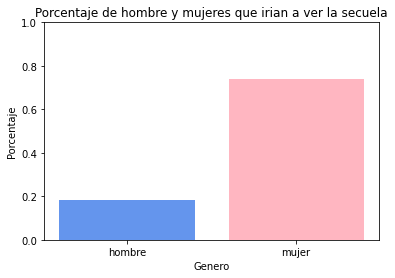

In [24]:
porcentaje_genero_volveria = info_fiumark_df.groupby(by='genero')['volveria'].agg('mean')
plt.bar(porcentaje_genero_volveria.index, porcentaje_genero_volveria.values, color = ['cornflowerblue','lightpink'])
plt.ylabel("Porcentaje")
plt.xlabel("Genero")
plt.ylim(0, 1)
plt.title('Porcentaje de hombre y mujeres que irian a ver la secuela')
plt.show()

El grafico nos dice que del total de mujeres que fue a ver la pelicula un 74% de ellas volveria a ver la secuela. Mientras que solo el 18% de los hombres consideraron que la pelicula disfruto la pelicula lo suficiente como para querer ir a ver la secuela.

#### ¿Por que hubo tantos hombres fueron incialmente a ver la pelicula?

Estas observaciones nos hicieron preguntarnos esta pregunta. Nuestra hipotesis es que pueden ser padres que llevaron a sus hijos a ver la pelicula.

Para responder esta pregunta buscamos primero ver la distribucion de las edades de los hombres y las mujeres, para ello realizamos un boxplot.

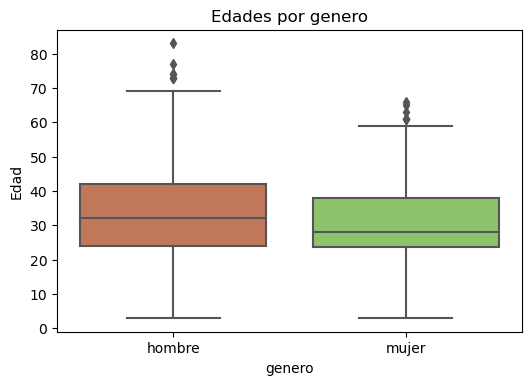

In [25]:
plt.figure(dpi=100)

plt.title("Edades por genero")
sns.boxplot(
    data= info_fiumark_df[['genero','edad']],
    y='edad',
    x='genero',
    palette=['#D17049', "#89D15E"],
)
plt.ylabel("Edad")
plt.xticks([False, True])
plt.show()

Podemos ver que la edad mediana de los hombres que fueron a ver la pelicula es ligeramente mayor, y que el 50% de la poblacion de los hombres se ubica en edades mayores que la de las mujeres. Seguimos investigando con respeto a si llevaron parientes, para obtener una mejor idea.

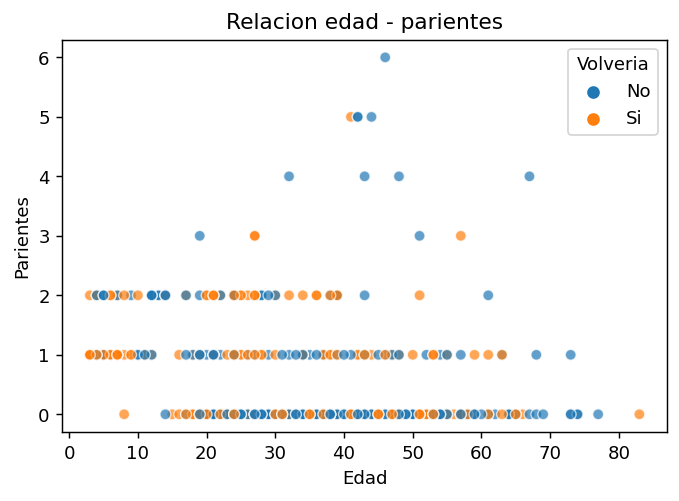

In [26]:
plt.figure(dpi=130)
sns.scatterplot(
    x='edad',
    y='parientes',
    hue=info_fiumark_df['volveria'].replace([0,1],['No','Si']).tolist(),
    data=info_fiumark_df,
    alpha=0.7,
)
plt.legend(title="Volveria")
plt.ylabel("Parientes")
plt.xlabel("Edad")
plt.title('Relacion edad - parientes')
plt.show()

Podemos ver que las personas mayores de treinta no necesariamente fueron acompañandos de un pariente, ya que parece que tenemos varios casos en donde fueron sin uno.


Veamos lo que nos habiamos propuesto de los padres.

In [27]:
mayor_a_treinta = info_fiumark_df['edad'] >= 30
con_pariente = info_fiumark_df['parientes'] >= 1
es_hombre = info_fiumark_df['genero'].str.contains('hombre')

In [28]:
info_fiumark_df.loc[mayor_a_treinta & con_pariente & es_hombre,'nombre'].count()

27

In [29]:
info_fiumark_df.loc[mayor_a_treinta & (~con_pariente) & es_hombre,'nombre'].count()

203

Vemos que la cantidad de casos sin pariente de los hombres es muy mayor a la de los que suponemos deben de ser padres, por lo que descartamos la hipotesis.

Para concluir la pregunta que nos habiamos planteado, pensamos que otro motivo por el que nos aparece que fueron mas hombres que mujeres, es que puede llegar a ser que los hombres simplemente fueron mas propensos a completar la encuesta que las mujeres.

Vemos como se distribuye la pregunta anterior de los niños en el caso de las mujeres.

In [30]:
info_fiumark_df.loc[mayor_a_treinta & con_pariente & (~es_hombre),'nombre'].count()

45

In [31]:
info_fiumark_df.loc[mayor_a_treinta & (~con_pariente) & (~es_hombre),'nombre'].count()

92

Notamos que parece una situacion mas "equilibrada" que en el caso de los hombres.

#### Niños y parientes

Una cosa que nos permitio ver el scatter plot anterior, es ver que los niños de entre 0 y 10 anios van acompañados por un adulto, algo que es esperable. Ademas los niños que fueron acompaniados por exactamente 1 adulto pareciera que disfrutaron mas la pelicula que los que fueron acopaniados por 2. Vemos cuan valida seria esta afirmacion viendo la cantidad de casos que tenemos cumpliendo esto.

In [32]:
menor_10_anios = info_fiumark_df['edad'] <= 10
un_pariente = info_fiumark_df['parientes'] == 1
dos_parientes = info_fiumark_df['parientes'] == 2
vuelve = info_fiumark_df['volveria'] == 1


In [33]:
cant_ninio_un_pariente_total = info_fiumark_df.loc[menor_10_anios & un_pariente,'nombre'].count() # Nos quedamos con cualquier fila, solo nos interesa saber cuantos son
cant_ninio_un_pariente_vuelve = info_fiumark_df.loc[menor_10_anios & un_pariente & vuelve,'nombre'].count()
cant_ninio_dos_pariente_total = info_fiumark_df.loc[menor_10_anios & dos_parientes,'nombre'].count()
cant_ninio_dos_pariente_vuelve = info_fiumark_df.loc[menor_10_anios & dos_parientes & vuelve,'nombre'].count()

In [34]:
print("Menores a 10, con un pariente: ",cant_ninio_un_pariente_total)
print("Menores a 10, con un pariente que vuelven: ",cant_ninio_un_pariente_vuelve)
print("Menores a 10, con un pariente: ",cant_ninio_dos_pariente_total)
print("Menores a 10, con dos pariente que vuelven: ",cant_ninio_dos_pariente_vuelve)

Menores a 10, con un pariente:  26
Menores a 10, con un pariente que vuelven:  19
Menores a 10, con un pariente:  15
Menores a 10, con dos pariente que vuelven:  9


Observamos que son pocos casos como para considerar que es algo muy determinante, sin embargo se ve que lo propuesto inicialmente con respecto a los niños se cumple.

### ¿Como es la relacion con la edad?

Busquemos ahora como se distribuye la edad de las personas que respondieron la encuesta.

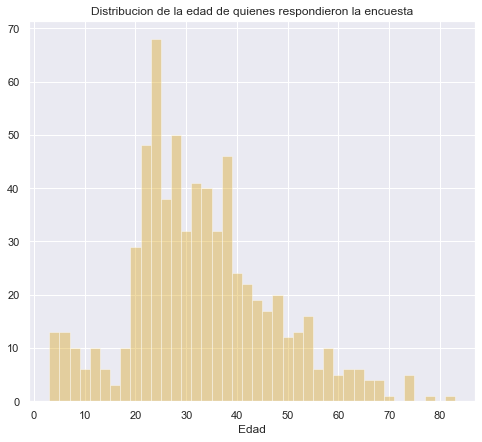

In [35]:
sns.set(rc={'figure.figsize':(8,7)})
g=sns.distplot( a=info_fiumark_df['edad'],
             hist=True, kde=False, rug=False,
             bins=40,
             axlabel='Edad',
             color='goldenrod')
g.set_title('Distribucion de la edad de quienes respondieron la encuesta')

plt.show()

Vemos que la gran mayoria de los que respondieron la encuesta esta en el rango de entre 20 y 50 años de edad.

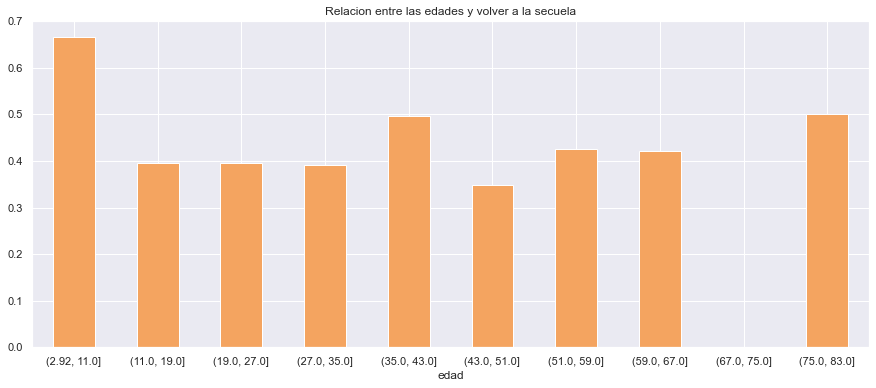

In [36]:

edades_cortadas = pd.cut(info_fiumark_df['edad'], bins = 10)

info_fiumark_df.groupby(edades_cortadas)['volveria'].mean().plot(kind='bar',rot=0,figsize=(15,6),color='sandybrown',
                                                                 title='Relacion entre las edades y volver a la secuela',
                                                                )

#### Cruzamos el genero con la edad

Intentemos relacionar ahora la edad de las personas y su genero con si volverian o no a ver la pelicula. Para eso 
agrupamos en hombres y mujeres y luego estos grupos por edad:

In [37]:
edad =  info_fiumark_df['edad']
genero = info_fiumark_df['genero']
volveria = info_fiumark_df['volveria']

hombres_vuelven = info_fiumark_df.loc[genero.str.contains('hombre') & (volveria == 1)]
hombres_total = info_fiumark_df.loc[genero.str.contains('hombre')]

mujeres_vuelven = info_fiumark_df.loc[genero.str.contains('mujer') & (volveria == 1)]
mujeres_total = info_fiumark_df.loc[genero.str.contains('mujer')]

In [38]:
rango_edades = [0, 10, 20, 30, 40, 50, 60, 70, 80]

cuts_total_mujeres = pd.cut(mujeres_total['edad'], bins = rango_edades)
cuts_vuelven_mujeres = pd.cut(mujeres_vuelven['edad'], bins = rango_edades)

cuts_total_hombres = pd.cut(hombres_total['edad'], bins = rango_edades)
cuts_vuelven_hombres = pd.cut(hombres_vuelven['edad'], bins = rango_edades)

In [39]:
serie_hombres = pd.Series(cuts_vuelven_hombres.value_counts()/cuts_total_hombres.value_counts())
serie_mujeres = pd.Series(cuts_vuelven_mujeres.value_counts()/cuts_total_mujeres.value_counts())

<Figure size 800x700 with 0 Axes>

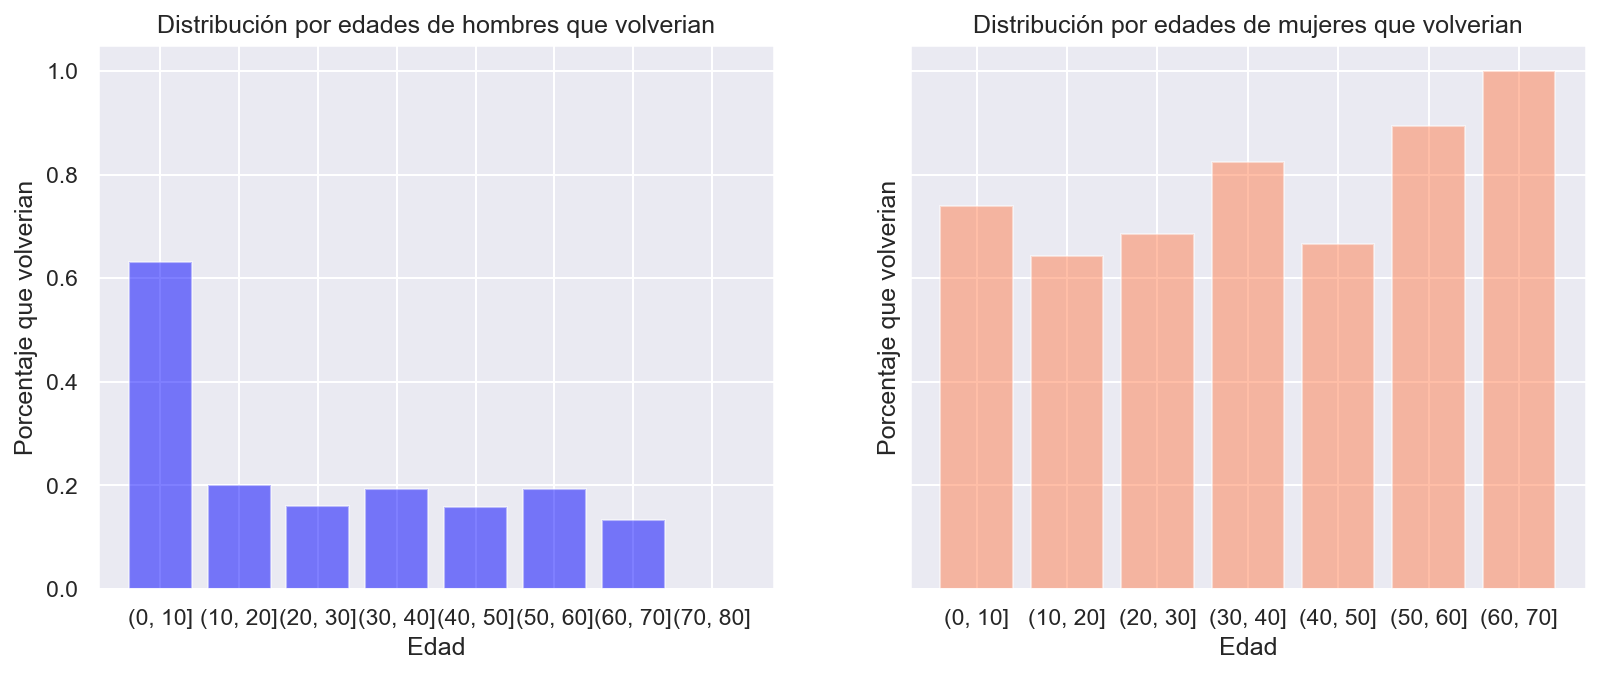

In [40]:
plt.figure(dpi=100)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, dpi=150, figsize=(6.4 * 2, 4.8))

axes[0].bar(serie_hombres.index.astype(str), serie_hombres.values, color = 'blue', alpha = 0.5)

axes[0].set_title("Distribución por edades de hombres que volverian")
axes[0].set_xlabel("Edad")
axes[0].set_ylabel("Porcentaje que volverian")

axes[1].bar(serie_mujeres.index.astype(str), serie_mujeres.values, color = 'coral', alpha = 0.5)

axes[1].set_title("Distribución por edades de mujeres que volverian")
axes[1].set_xlabel("Edad")
axes[1].set_ylabel("Porcentaje que volverian")

plt.show()

Se puede ver claramente que a los hombres de edades entre 0 y 10 les gusto mucho mas que al resto de los hombres.
Por otro lado el porcentaje de mujeres que volverian a ver la pelicula es mayor que el de hombres para todos los rangos de edades y parece ir ligeramente aumentando con la edad.

#### Cruzamos edad con cantidad de amigos

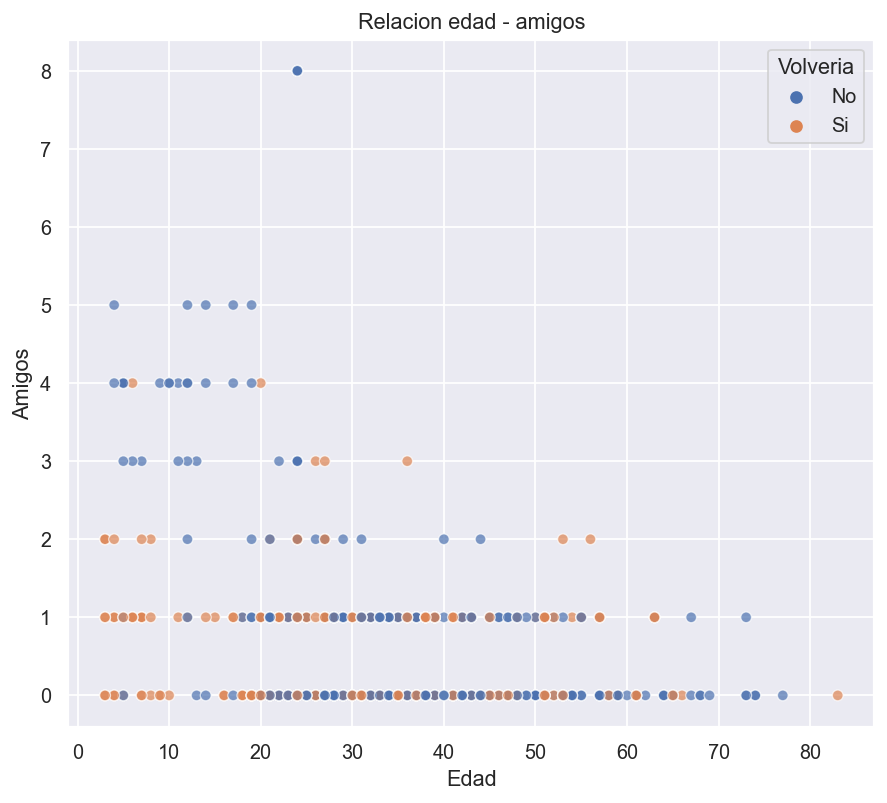

In [41]:
plt.figure(dpi=130)
sns.scatterplot(
    x='edad',
    y='amigos',
    hue=info_fiumark_df['volveria'].replace([0,1],['No','Si']).tolist(),
    data=info_fiumark_df,
    alpha=0.7,
)
plt.legend(title="Volveria")
plt.ylabel("Amigos")
plt.xlabel("Edad")
plt.title('Relacion edad - amigos')
plt.show()

En este scatter plot podemos ver que los jovenes menores a 20 años tienden a disfrutar la pelicula si fueron con
hasta 2 amigos. Si fueron con 3 amigos o mas tienden a no querer volver a ver la secuela por lo que se ve.

Buscamos de cuantos casos estamos hablando.

In [115]:
fue_con_varios_amigos = info_fiumark_df['amigos']>=3
volveria =  info_fiumark_df['volveria']==1
menor_a_veinte = info_fiumark_df['edad']<=20

In [116]:
info_fiumark_df.loc[(~fue_con_varios_amigos) & menor_a_veinte]['nombre'].count()

74

In [73]:
info_fiumark_df.loc[(~fue_con_varios_amigos) & menor_a_veinte & volveria]['nombre'].count()

51

Vemos cuantos son si fue con varios amigos ahora.

In [74]:
info_fiumark_df.loc[fue_con_varios_amigos]['nombre'].count()

40

In [70]:
info_fiumark_df.loc[fue_con_varios_amigos & volveria]['nombre'].count()

5

Vemos que lo observado es correcto, aunque son pocos casos de la muestra analizada.

### ¿Afecta en algo el ir a disitintos tipos de sala la decision?

Veamos ahora si la decision de ir a un tipo de sala mejor determina si se vuelve a ver la secuela. 

Para empezar veamos cuales hay.

In [42]:
cantidad_salas = info_fiumark_df['tipo_de_sala'].value_counts()
cantidad_salas

4d        447
normal    187
3d        167
Name: tipo_de_sala, dtype: int64

Sorprendentemente, la mayoria de la gente que fue a ver la pelicula decidio ir a las salas especiales (4D y 3D). Esto se puede deber a que se busca tener una experiencia unica al momento de ir al cine. Esto lo mostramos en el siguiente grafico con respecto a la cantidad total de gente que fue.

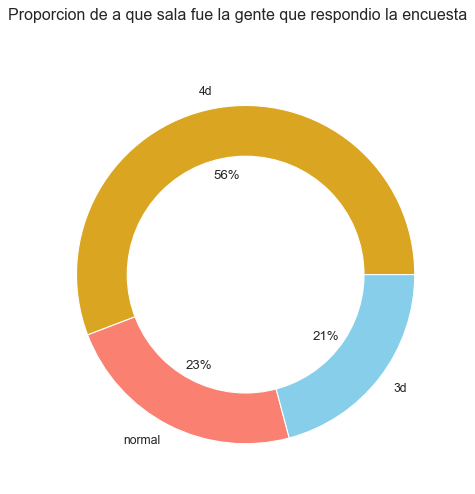

In [43]:
circulo_centro=plt.Circle( (0,0), 0.7, color='white')
plt.figure(dpi=80)
plt.pie(cantidad_salas.values, labels=cantidad_salas.index.to_list(), colors=['goldenrod','salmon','skyblue'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(circulo_centro)
plt.suptitle('Proporcion de a que sala fue la gente que respondio la encuesta')
plt.show()

Busquemos ahora si hay relacion con la secuela.


In [44]:
porcentaje_volveria_salas = info_fiumark_df.groupby(by='tipo_de_sala')['volveria'].agg('mean').round(2)
porcentaje_volveria_salas

tipo_de_sala
3d        0.49
4d        0.23
normal    0.64
Name: volveria, dtype: float64

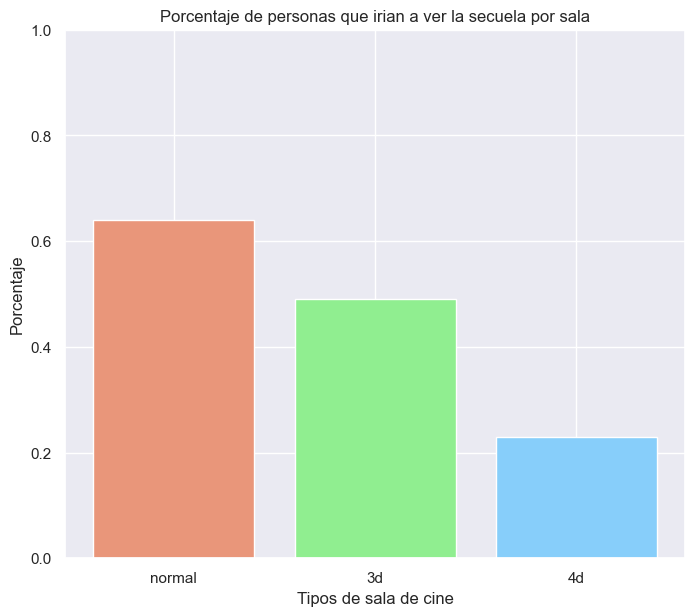

In [45]:
porcentaje_volveria_salas.sort_values(ascending=False,inplace=True)
plt.figure(dpi=100)
plt.bar(porcentaje_volveria_salas.index, porcentaje_volveria_salas.values, color = ['darksalmon','lightgreen','lightskyblue'])
plt.ylabel("Porcentaje")
plt.xlabel("Tipos de sala de cine")
plt.ylim(0, 1)
plt.title('Porcentaje de personas que irian a ver la secuela por sala')
plt.show()

Observando los resultados, notamos que una gran cantidad de la gente que fue a la sala 4D, decidio que no volveria a ver la secuela (cercano al 80%). Uno de los motivos por los que esto puede llegar a ser es que las personas que deciden ir a esta sala esperan tener una gran experiencia debido a los efectos que agrega la sala, ya sean movimientos, niebla, lluvia, u otros efectos del estilo, los cuales pueden no estar siendo aprovechados del todo durante la proyeccion de la pelicula.


Con respecto a la sala 3D, podemos decir que no nos estaria aportando mucho por si sola. Esto se debe a que la mitad de la gente que decide ir a esta sala volveria a la secuela, mientras que el resto no. Resultando como si fuera el lanzamiento de una moneda.

Por ultimo, de la sala normal podemos decir que cerca del 64% dijo que vovleria a la secuela. Que una mayor cantidad diga en esta sala que volveria puede deberse a que ya conocieran de antes la serie de peliculas Frozen.

Veamos si podemos obtener algun refinamiento de estos datos cruzandola con la variable 'genero'.

#### Cruzamos el tipo de sala con el genero

In [46]:
porcentaje_sala_sexo = info_fiumark_df.groupby(by=['tipo_de_sala','genero'])['volveria'].agg('mean').round(2).unstack().T
porcentaje_sala_sexo = porcentaje_sala_sexo.mul(100)
porcentaje_sala_sexo

tipo_de_sala,3d,4d,normal
genero,,,
hombre,16.0,13.0,36.0
mujer,94.0,48.0,97.0


Vemos que las mujeres son mas probables a responder que volverian en todos los casos, estando en valores mayores al 90% para las salas normal y 3D. Ademas vemos que estan muy por arriba del promedio de los hombres en todos los casos. Algo a notar con respecto a los hombres es que parecen querer volver algo mas si es que fueron a la sala normal en comparacion con el resto.

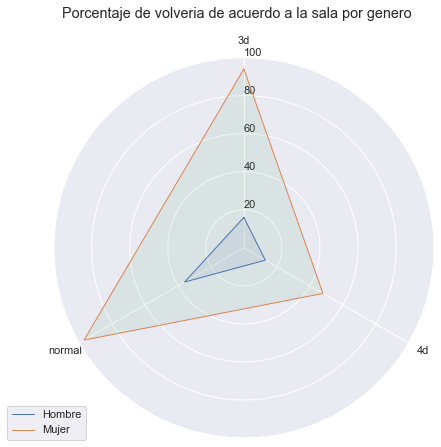

In [47]:
# -------Creamos el fondo
categorias=list(porcentaje_sala_sexo)[0:]
cantidad_categorias = len(categorias)
 
# Armamos el angulo de cada eje
angulos = [n / float(cantidad_categorias) * 2 * pi for n in range(cantidad_categorias)]
angulos += angulos[:1]
 
# Inicializamos el plot
ax = plt.subplot(111, polar=True)
 
# El primer eje esta arriba
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Dibujamos los ejes y los nombres
plt.xticks(angulos[:-1], categorias)

# Etiquetas en el eje y
ax.set_rlabel_position(0)
plt.ylim(0,100)

# Primer grupo
values1=porcentaje_sala_sexo.iloc[0].values.tolist()
values1 += values1[:1]
ax.plot(angulos, values1, linewidth=1, linestyle='solid', label="Hombre")
ax.fill(angulos, values1, 'b', alpha=0.1)

# Segundo grupo
values2=porcentaje_sala_sexo.iloc[1].values.tolist()
values2 += values2[:1]
ax.plot(angulos, values2, linewidth=1, linestyle='solid', label="Mujer")
ax.fill(angulos, values2, 'g', alpha=0.1)
##
plt.suptitle('Porcentaje de volveria de acuerdo a la sala por genero')
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

Algo curioso que se nota al observar el grafico, es que parece como si el caso de los hombres siguiera el mismo estilo que el de las mujeres, solo que con un tamaño menor.

### ¿Hay mas gente que iria a la secuela si fue a una sede en particular?

En esta pregunta nos interesa saber si por algun motivo alguna sede en particular ayuda a influenciar la ida a la secuela. Los motivos por los que esto podria llegar a suceder pueden ser por la calidad del cine.

Empecemos viendo cuantas sedes tenemos y como se distribuyo la cantidad de gente que fue a cada una. De ahi veremos si surge que en alguna sede dicen de ir a la secuela.

In [48]:
info_fiumark_df['nombre_sede'].value_counts(normalize=True).round(2)

fiumark_palermo      0.72
fiumark_chacarita    0.19
fiumark_quilmes      0.09
Name: nombre_sede, dtype: float64

Observando lo obtenido, notamos que tenemos 3 sedes y que la mayoria de los encuestados corresponden a la cede de Fiumark en Palermo.

In [49]:
info_fiumark_df.groupby(by='nombre_sede').agg({'volveria':'mean'}).round(2)

,volveria
nombre_sede,
fiumark_chacarita,0.56
fiumark_palermo,0.34
fiumark_quilmes,0.38


Al ver cuantos volverian por sede, obtenemos que la sede no parece ser tan determinante por si sola, quizas podemos mencionar que en la de Palermo parece que se tiende a que no se volveria.

In [75]:
volveria_por_sede = info_fiumark_df.groupby(by="nombre_sede")['volveria'].value_counts(normalize=True)
volveria_por_sede_df = volveria_por_sede.to_frame()
volveria_por_sede_df.rename(columns={'volveria':'Cantidad de respuestas'},inplace=True)
volveria_por_sede_df.reset_index(inplace=True)
volveria_por_sede_df.rename(columns={'volveria':'Vuelve a la secuela','nombre_sede':'Sedes'},inplace=True)

In [51]:
volveria_por_sede_df['Vuelve a la secuela'].replace([0,1],['No','Si'],inplace=True)

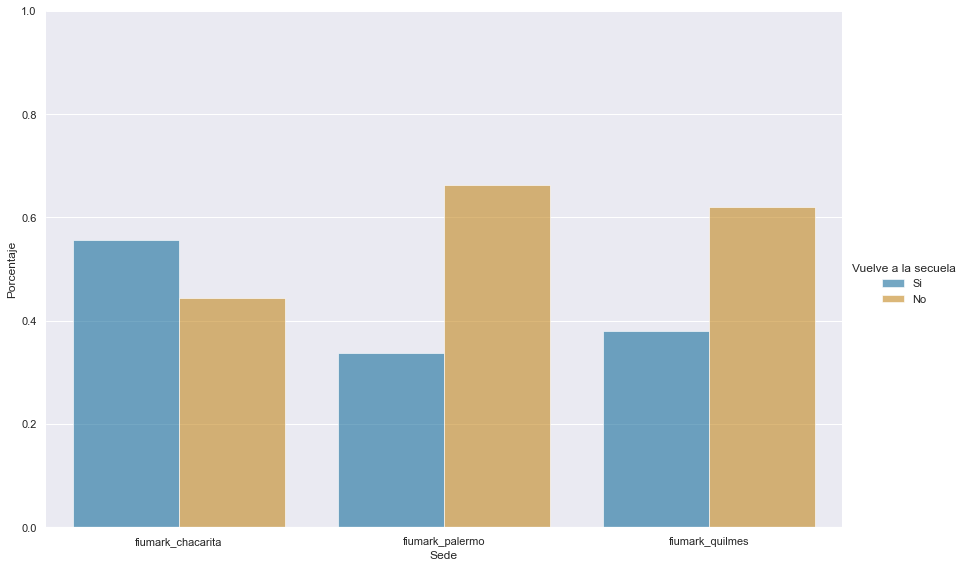

In [52]:
g = sns.catplot(
    data=volveria_por_sede_df, kind="bar",
    x="Sedes", y="Cantidad de respuestas", hue="Vuelve a la secuela",
    ci=None, palette="colorblind", alpha=.6, height=8,aspect=1.5
)
g.despine(left=True)
plt.ylim(0,1)
g.set_axis_labels("Sede", "Porcentaje")

#### ¿Tendra algo que ver el genero con la sede?

In [109]:
sede_genero = info_fiumark_df.groupby(by=["nombre_sede","genero"]).agg({'volveria':'mean'})
sede_genero = sede_genero.unstack('nombre_sede').round(2)
sede_genero.columns = sede_genero.columns.get_level_values(1)
sede_genero

nombre_sede,fiumark_chacarita,fiumark_palermo,fiumark_quilmes
genero,,,
hombre,0.29,0.17,0.08
mujer,0.89,0.68,0.73


Vemos que devuelta las mujeres dicen que vuelven en todos los casos mucho mas que los hombres.

### ¿El precio fue determinante?

Veamos primero como se distribuyen los precios, y despues la relacion con respecto a la variable de interes.

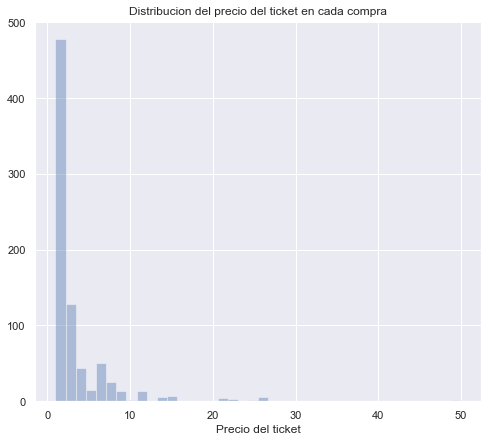

In [53]:
sns.set(rc={'figure.figsize':(8,7)})
g=sns.distplot( a=info_fiumark_df['precio_ticket'],
             hist=True, kde=False, rug=False,
             bins=40,
             axlabel='Precio del ticket')
g.set_title('Distribucion del precio del ticket en cada compra')

plt.show()

Podemos observar que la mayoria de los que fueron a ver la pelicula pago precios inferiores a 10, con algunos casos excepcionales que pagaron alrededor de 50. Veamos la relacion ahora, para ello creamos categorias en las cuales al comienzo son mas especificas debido a la cantidad de casos, y hacia el final creamos una que agrupe todas.

In [54]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, np.inf]
rango_precios = pd.cut(info_fiumark_df['precio_ticket'], bins=bins)

volveria_por_rango_precio = info_fiumark_df.groupby(by=rango_precios)['volveria'].value_counts()
volveria_por_rango_precio_df = volveria_por_rango_precio.to_frame()
volveria_por_rango_precio_df.rename(columns={'volveria':'Cantidad de respuestas'},inplace=True)
volveria_por_rango_precio_df.reset_index(inplace=True)
volveria_por_rango_precio_df.rename(columns={'volveria':'Vuelve a la secuela','precio_ticket':'Rango de precios'},inplace=True)

In [55]:
volveria_por_rango_precio_df['Vuelve a la secuela'].replace([0,1],['No','Si'],inplace=True)

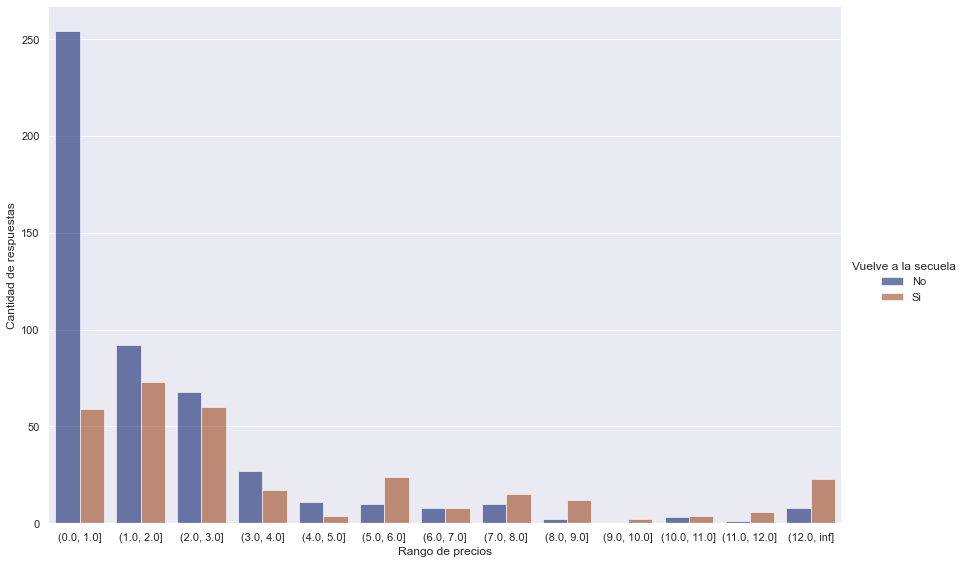

In [56]:
g = sns.catplot(
    data=volveria_por_rango_precio_df, kind="bar",
    x="Rango de precios", y="Cantidad de respuestas", hue="Vuelve a la secuela",
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
g.despine(left=True)
g.set_axis_labels("Rango de precios", "Cantidad de respuestas")

Veamos ahora normalizado que obtenemos.

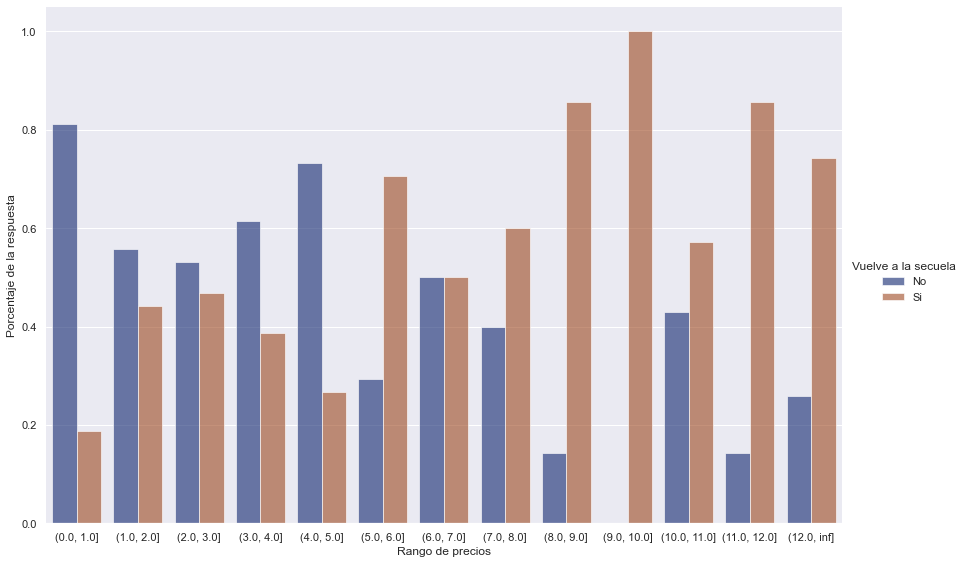

In [57]:
volveria_por_rango_precio = info_fiumark_df.groupby(by=rango_precios)['volveria'].value_counts(normalize=True)
volveria_por_rango_precio_df = volveria_por_rango_precio.to_frame()
volveria_por_rango_precio_df.rename(columns={'volveria':'Cantidad de respuestas'},inplace=True)
volveria_por_rango_precio_df.reset_index(inplace=True)
volveria_por_rango_precio_df.rename(columns={'volveria':'Vuelve a la secuela','precio_ticket':'Rango de precios'},inplace=True)
volveria_por_rango_precio_df['Vuelve a la secuela'].replace([0,1],['No','Si'],inplace=True)

g = sns.catplot(
    data=volveria_por_rango_precio_df, kind="bar",
    x="Rango de precios", y="Cantidad de respuestas", hue="Vuelve a la secuela",
    ci=None, palette="dark", alpha=.6, height=8,aspect=1.5
)
g.despine(left=True)
g.set_axis_labels("Rango de precios", "Porcentaje de la respuesta")

Lo que nos encontramos es que en el rango mas bajo (de 0 a 1) la mayoria respondio que no volveria, mientras que a partir de que se empieza a incrementar el precio aumenta la cantidad de gente que responde que vuelve. Una hipotesis respecto a esto puede ser que la gente que gasto mas se convence que el gasto realizado valio la pena, de forma tal de que se van con una mejor opinion respecto a la pelicula y una potencial secuela.

#### Cruzamos el precio con la edad

In [58]:
#Sacamos los valores que estarian muy lejos, debido a que arruinan la escala.
precio_menor_a_treinta = info_fiumark_df.loc[info_fiumark_df["precio_ticket"]<30]
precio_menor_a_treinta = precio_menor_a_treinta.rename(columns={'volveria':'Vuelve a la secuela','precio_ticket':'Precios','edad':'Edad'})
precio_menor_a_treinta['Vuelve a la secuela'].replace([0,1],['No','Si'],inplace=True)

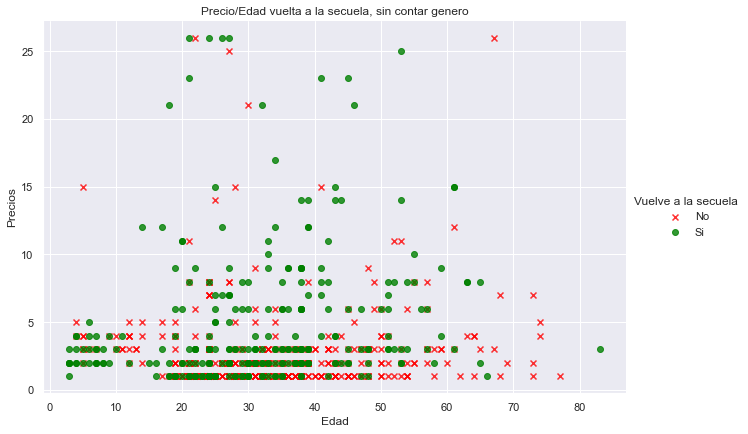

In [59]:

sns.lmplot( x='Edad', y='Precios',data=precio_menor_a_treinta,fit_reg=False, hue='Vuelve a la secuela', legend=True,height=6,aspect=1.5,markers=["x","o"],palette=['red','green'])
plt.title("Precio/Edad vuelta a la secuela, sin contar genero")
plt.show()

In [60]:
precio_menor_a_treinta_hombre = precio_menor_a_treinta.loc[precio_menor_a_treinta['genero'].str.contains('hombre')]
precio_menor_a_treinta_mujer = precio_menor_a_treinta.loc[precio_menor_a_treinta['genero'].str.contains('mujer')]

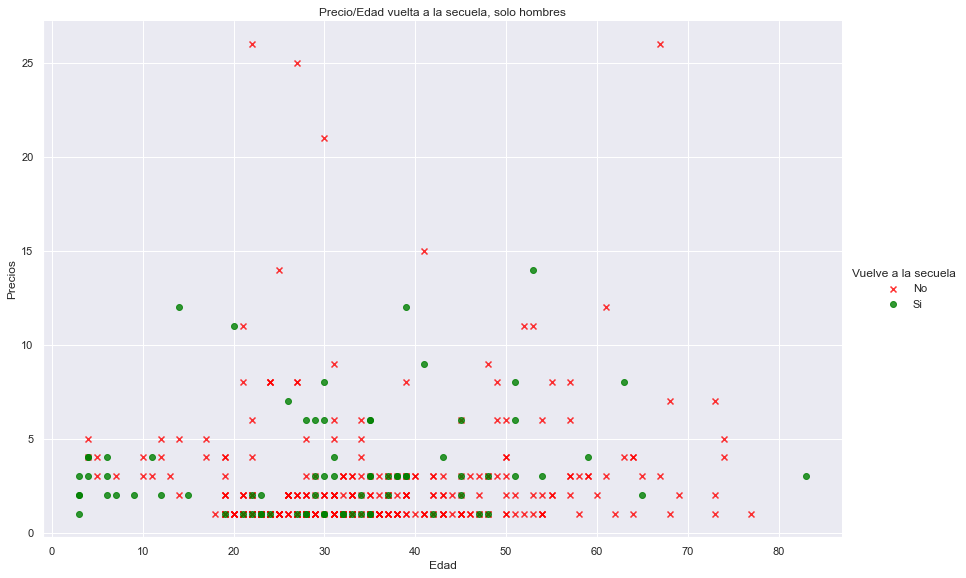

In [61]:
sns.lmplot( x='Edad', y='Precios',data=precio_menor_a_treinta_hombre,fit_reg=False, hue='Vuelve a la secuela', legend=True,height=8,aspect=1.5,markers=["x","o"],palette=['red','green'])
plt.title("Precio/Edad vuelta a la secuela, solo hombres")
plt.show()

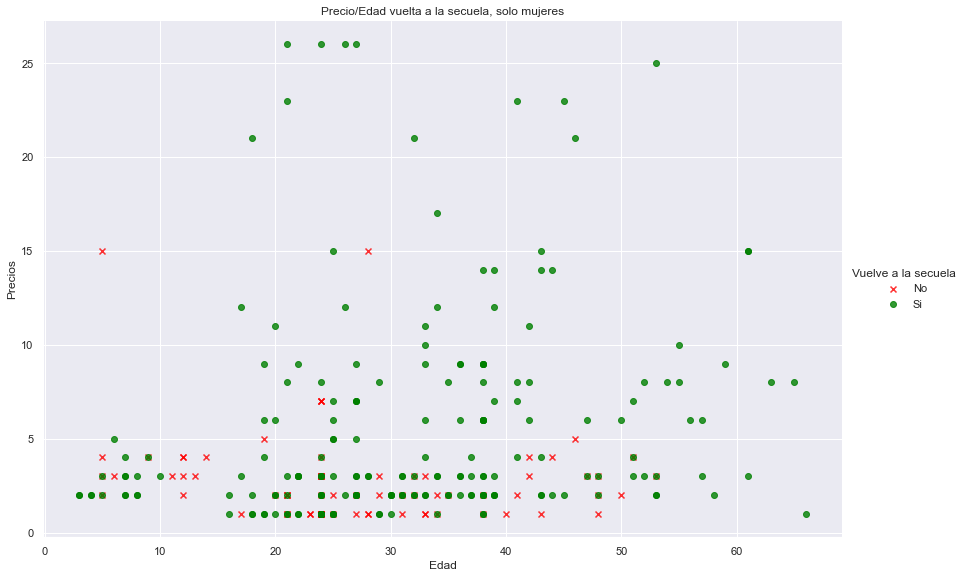

In [62]:
sns.lmplot( x='Edad', y='Precios',data=precio_menor_a_treinta_mujer,fit_reg=False, hue='Vuelve a la secuela', legend=True,height=8,aspect=1.5,markers=["x","o"],palette=['red','green'])
plt.title("Precio/Edad vuelta a la secuela, solo mujeres")
plt.show()

Observando todos los graficos hechos, notamos que en el primer grafico teniamos ruido al tener ambos generos juntos, pero al separarlos se puede ver claramente la diferencia. Con respecto a los hombres la gran mayoria dice de no volver, independientemente de la edad y el precio, y para el caso de las mujeres sucede lo contrario, estas volverian independientemente tambien de la edad y del precio.

### ¿La ubicacion en la sala importa?

Veamos ahora si podemos llegar a sacar alguna conclusion interesante sobre las filas. Lo primero que debemos de tener en cuenta antes de comenzar, es que este atributo tiene en su gran mayoria valores nulos que fueron remplazados por 'No responde'.

In [63]:
info_fiumark_df['fila'].value_counts()

No responde    624
adelante       164
medio           13
Name: fila, dtype: int64

Buscamos la proporcion de gente que vuelve.

In [64]:
vuelta_por_fila = info_fiumark_df.groupby(by='fila').agg({'volveria':'mean'}).round(2)
vuelta_por_fila

,volveria
fila,
No responde,0.30
adelante,0.69
medio,0.54


Observamos que cerca del 70% de los que respondieron que se sentaron adelante volverian, siendo el valor 'adelante' el que mas respuestas tuvo excluyendo a los nulos. Sin embargo, aun siendo este el caso, este atributo cuenta con muy pocas respuestas como para considerarse algo bien determinante.

En el caso del 'medio', no podemos concluir nada debido a las muy pocas respuestas obtenidas. Con respecto a los que no respondieron no tendriamos informacion suficiente, ya que estos valores en la realidad estan distribuidos en 'adelante', 'medio', y muy posiblemente 'atras'.




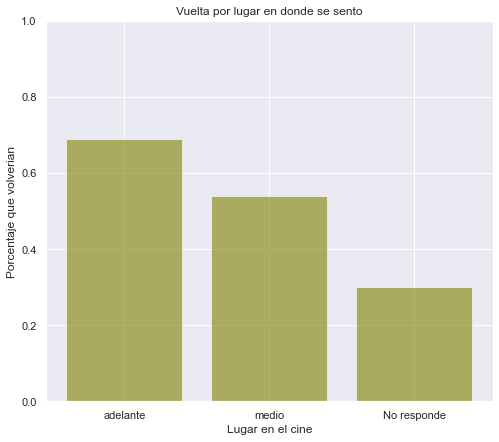

In [65]:
vuelta_por_fila.sort_values(by='volveria',ascending=False,inplace=True)
plt.bar(vuelta_por_fila.index.astype(str), vuelta_por_fila['volveria'], color = 'olive', alpha = 0.6)
plt.title("Vuelta por lugar en donde se sento")
plt.xlabel("Lugar en el cine")
plt.ylabel("Porcentaje que volverian")
plt.ylim(0, 1)
plt.show()

#### Vemos con los generos como es el comportamiento

In [168]:
info_fiumark_df.groupby(by=['fila','genero']).agg({'volveria':['mean','sum']}).round(2)

volveria     
                       mean  sum
fila        genero              
No responde hombre     0.14   60
            mujer      0.64  127
adelante    hombre     0.40   32
            mujer      0.96   81
medio       hombre     0.33    2
            mujer      0.71    5

# VER QUE HACEMOS CON ESTO

In [180]:
info_fiumark_df.groupby(by=['fila','tipo_de_sala','genero']).agg({'volveria':['mean','sum']}).round(2).unstack() 

volveria                   
                             mean          sum      
genero                     hombre mujer hombre mujer
fila        tipo_de_sala                            
No responde 3d               0.14  0.93   13.0  57.0
            4d               0.13  0.48   41.0  60.0
            normal           0.26  1.00    6.0  10.0
adelante    3d               0.50  1.00    1.0   5.0
            4d               1.00  1.00    1.0   2.0
            normal           0.39  0.96   30.0  74.0
medio       3d               1.00  1.00    2.0   4.0
            4d               0.00  0.33    0.0   1.0
            normal            NaN   NaN    NaN   NaN

## Conclusiones del analisis

A partir de los datos recolectados hemos podido obtener las siguientes conclusiones:
    
- Los dos factores mas relevantes para identificar si una persona iria a ver Frozen 4 son el genero y la edad.

- Las mujeres son mucho mas propensas a querer ver la secuela que lo hombres para todo rango de edad.

- Aproximadamente el 60% de los hombres de edades entre 0 y 10 años veria la secuela, mientras que para el resto de los hombres este numero baja a un 20% aproximadamente. Esta muestra tambien una clara relacion entre el genero y la edad.

- Las personas que pagaron su ticket a un precio mayor que 5 tienden a querer ver la secuela mas que aquellas que no lo hicieron, siendo este el caso en su mayoria de las mujeres.

- Aproximadamente, un 60% de las personas que fueron a una sala normal volveria al cine a ver Frozen 4 mientras que un 80% de las personas que fueron a una sala 4D no volverian. Esto pareceria indicar que las salas 4D no estarian otorgando una experiencia lo suficientemente buena para que la gente vuelva. Devuelta en este caso las mujeres indicaron que volverian mas veces que los hombres en todas las salas.

- Pudimos ver que para un pequeño subconjunto de los datos, las variables 'parientes' y 'amigos' estan relacionadas con la edad.

- Las personas que van con 3 o mas amigos no parece que tiendan a disfrutar la pelicula lo suficiente como para volver a ver la secuela.

- La sede no parece ser un factor muy importante para decidir si vuelven o no.

In [66]:
#Explicar qué conclusiones se pueden llegar a partir de analizar los datos recolectados. 
#La empresa quiere saber cómo entender cada uno de los datos, cómo se relacionan entre sí
#Si se puede sacar alguna conclusión o descubrir un patrón a partir de estos. 
#Adicionalmente quieren saber cuáles son los factores más importantes que determinan si un usuario va a ir al cine a ver Frozen 4 o no.

## Baseline

In [163]:
#A partir de todo el análisis anterior, construir el código baseline que se va a usar para la primera ronda de campaña digital.
#Fundamentar el código basándose en las conclusiones de los anteriores puntos.
#La función baseline debe llamarse baseline(X: pd.DataFrame) -> List[int]. la cual debe recibir un pandas dataframe producido de la lectura del archivo de testeo original y devolver una lista

def baseline(info_fiumark_df: pd.DataFrame):
 
    info_fiumark_df['puntaje'] = 0
    
    es_ninio = info_fiumark_df['edad']<=10
    es_joven = (info_fiumark_df['edad']<=20) & (info_fiumark_df['edad']>10)
    es_mayor = info_fiumark_df['edad']>40
    
    es_mujer = info_fiumark_df['genero'].str.contains('mujer') 
    es_hombre = info_fiumark_df['genero'].str.contains('hombre')
    fue_a_sala_normal = info_fiumark_df['tipo_de_sala'].str.contains('normal')
    fue_a_sala_3D =  info_fiumark_df['tipo_de_sala'].str.contains('3d')
    pago_mucho = info_fiumark_df['precio_ticket']>5
    fue_con_pocos_parientes = info_fiumark_df['parientes']<3
    fue_con_pocos_amigos = info_fiumark_df['amigos']<3
    se_sento_adelante = info_fiumark_df['fila'].str.contains('adelante')
        
    info_fiumark_df['puntaje'] = 0
    
    #EDAD - PARIENTES - AMIGOS
    info_fiumark_df.loc[es_ninio & fue_con_pocos_parientes & fue_con_pocos_amigos, 'puntaje'] = info_fiumark_df.loc[es_ninio & fue_con_pocos_parientes & fue_con_pocos_amigos, 'puntaje'] + 1
    info_fiumark_df.loc[es_joven & fue_con_pocos_amigos, 'puntaje'] = info_fiumark_df.loc[es_joven & fue_con_pocos_amigos, 'puntaje'] + 0.5    
    #PRECIO
    info_fiumark_df.loc[pago_mucho, 'puntaje'] = info_fiumark_df.loc[pago_mucho, 'puntaje'] + 0.5
    
    #SALA - GENERO
    info_fiumark_df.loc[fue_a_sala_normal & es_mujer, 'puntaje'] = info_fiumark_df.loc[fue_a_sala_normal & es_mujer, 'puntaje'] + 1
    info_fiumark_df.loc[fue_a_sala_3D & es_mujer, 'puntaje'] = info_fiumark_df.loc[fue_a_sala_3D & es_mujer, 'puntaje'] + 1
    info_fiumark_df.loc[(~fue_a_sala_3D) & (~fue_a_sala_normal) & es_mujer, 'puntaje'] = info_fiumark_df.loc[(~fue_a_sala_3D) & (~fue_a_sala_normal) & es_mujer, 'puntaje'] + 0.4
    info_fiumark_df.loc[fue_a_sala_normal & es_hombre, 'puntaje'] = info_fiumark_df.loc[fue_a_sala_normal & es_hombre, 'puntaje'] + 0.3
    
    #FILA
    info_fiumark_df.loc[se_sento_adelante, 'puntaje'] = info_fiumark_df.loc[se_sento_adelante, 'puntaje'] + 0.2
    
    info_fiumark_df['volveria_estimado'] = 0
    puntaje_suficiente = info_fiumark_df['puntaje']>=1
    info_fiumark_df.loc[puntaje_suficiente,'volveria_estimado'] = info_fiumark_df.loc[puntaje_suficiente,'volveria_estimado'] +1
    
    return info_fiumark_df['volveria_estimado']#.tolist()

El porcentaje de aciertos que obtuvimos es de 82%

In [164]:
(baseline(info_fiumark_df)==info_fiumark_df['volveria']).mean()

0.8064918851435705